In [224]:
import skimage as sk 
from skimage import io 
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import fft
from scipy import ndimage
from scipy.signal import gaussian, convolve
from skimage.feature import greycomatrix
from pdb import set_trace as st
import scipy as scipy

In [53]:
def read_img(im_name, to_float=True):
    im = io.imread(im_name)
    if to_float:
        im = sk.img_as_float(im).astype("float32")
    return im 

def normalize(im, to_int=False):
    normalized = (im.copy()-im.min())/(im.max()-im.min()+1e-8)
    if to_int:
        normalized = np.clip(normalized, 0, 1)
        normalized = (255*normalized).astype("uint8")
    return normalized

##### Part I: Objective Fidelity Criteria


In [118]:
def root_mean_sq_error(f, f_hat):
    return np.sqrt(np.mean((f_hat-f)**2))

def mean_sq_signal_to_noise_ratio(f, f_hat):
    return (f_hat**2).sum() / ((f_hat-f)**2).sum()

In [108]:
im = read_img('./Fig1.1.jpg', to_float=False)

In [109]:
def uniform_quantize(im, levels):
    assert levels <= 255
    quantized = np.floor(im*(levels/255))*(255/levels)
    return quantized.astype('uint8')

In [175]:
def igs_quantize(im, levels):
    least_sig_sum = 0
    result = []
    H, W = im.shape
    for i in range(H):
        row = []
        for j in range(W):
            random = im[i][j] + least_sig_sum
            least_sig_sum = random % (255/levels)
            row.append(random//(255/levels))
        result.append(np.array(row))

    return np.array(result).astype('uint8')

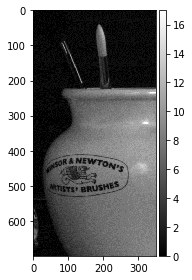

In [185]:
uniform_quantized = uniform_quantize(im.copy(), 16)
igs_quantized = igs_quantize(im.copy(), 16)
io.imshow(igs_quantized, cmap='gray')

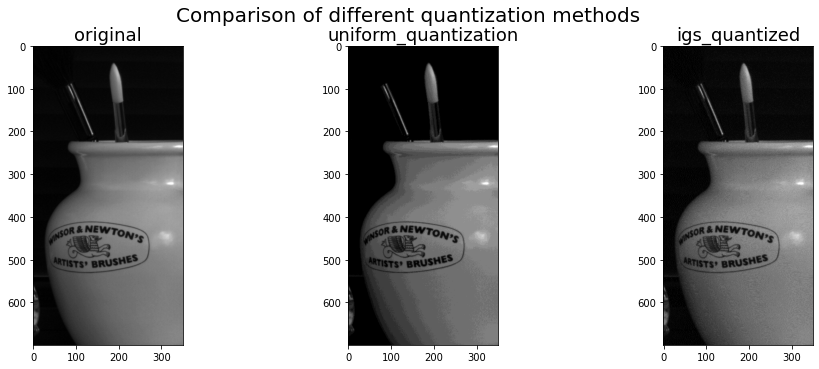

In [186]:
lst = [im, uniform_quantized, igs_quantized]
labels = ['original', 'uniform_quantization', 'igs_quantized']
f, axarr = plt.subplots(1, 3)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
fig.suptitle('Comparison of different quantization methods', fontsize=20)
for i, label in enumerate(labels):
    axarr[i].imshow(lst[i], cmap='gray')
    axarr[i].set_title(label, fontsize=18)

#### After uniform quantization is applied, there's some very noticeable edge effects. Applying igs quantization reduces edge effects but it makes the edges a bit blurry

In [187]:
print(root_mean_sq_error(im, uniform_quantized))
print(root_mean_sq_error(im, igs_quantized))

print(mean_sq_signal_to_noise_ratio(im, uniform_quantized))
print(mean_sq_signal_to_noise_ratio(im, igs_quantized))

8.299048875919334
8.959881558983936
0.8273138217899985
0.4224864036209829


#### The root-mean-squared error of uniform_quantization on the same level is lower than igs quantization, but its mean-squared signal-to-noise ratio is way higher

#### Part II: Image Entropy

In [165]:
def cal_entropy(im):
    flatten = np.ravel(im)
    hist = np.histogramdd(flatten, bins = 256)[0]/flatten.shape[0]
    hist = np.array(list(filter(lambda p: p > 0, hist)))
    entropy = -(hist * np.log2(hist)).sum()
    return entropy

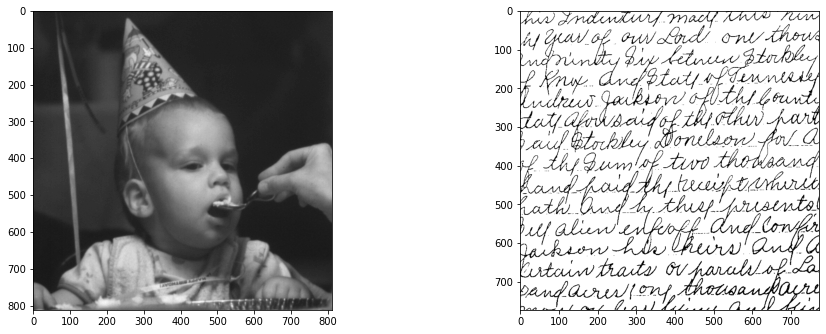

In [168]:
im2 = read_img('./Fig1.2(a).jpg', to_float=False)
im3 = read_img('./Fig1.2(b).tif', to_float=False)
lst = [im2, im3]
f, axarr = plt.subplots(1, 2)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
for i, image in enumerate(lst):
    axarr[i].imshow(image, cmap='gray')

In [167]:
print("estimated entropy of figure1.2(a):", cal_entropy(im2))
print("estimated entropy of figure1.2(b):", cal_entropy(im3))

estimated entropy of figure1.2(a): 6.8045517107235955
estimated entropy of figure1.2(b): 0.5299451662202398


#### Part III: Transform Coding

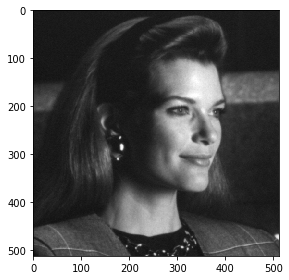

In [188]:
im4 = read_img('./Fig1.3.jpg', to_float=False)
io.imshow(im4)

In [271]:
def encode(image, transform="Fourier", bit=8, size=8):
    if transform == "Fourier":
        encoder = np.fft.fft2
    elif transform == "Cosine":
        encoder = lambda x:scipy.fftpack.dct(scipy.fftpack.dct(x, axis=0, norm='ortho'), axis=1, norm='ortho')
    H, W = image.shape
    result = np.zeros(image.shape)
    for i in range(0, H, size):
        for j in range(0, W, size):
            block = encoder(image[i:(i+size),j:(j+size)])
            threshold = np.sort(np.abs(block).flatten())[-bit]
            result[i:(i+size),j:(j+size)] = block * (np.abs(block)>=threshold)
    return result

def decode(im, encoded, size=8):
    H, W = im.shape
    result = np.zeros(im.shape)
    decoder = lambda x:scipy.fftpack.idct(scipy.fftpack.idct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

    for i in range(0, H, size):
        for j in range(0, W, size):
            result[i:(i+size),j:(j+size)] = decoder(encoded[i:(i+8),j:(j+8)] )
    return result

In [278]:
forward1 = encode(im4, "Fourier")
backward1 = decode(im4, forward1)

/Users/vioichigo/opt/anaconda3/envs/mjrl-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


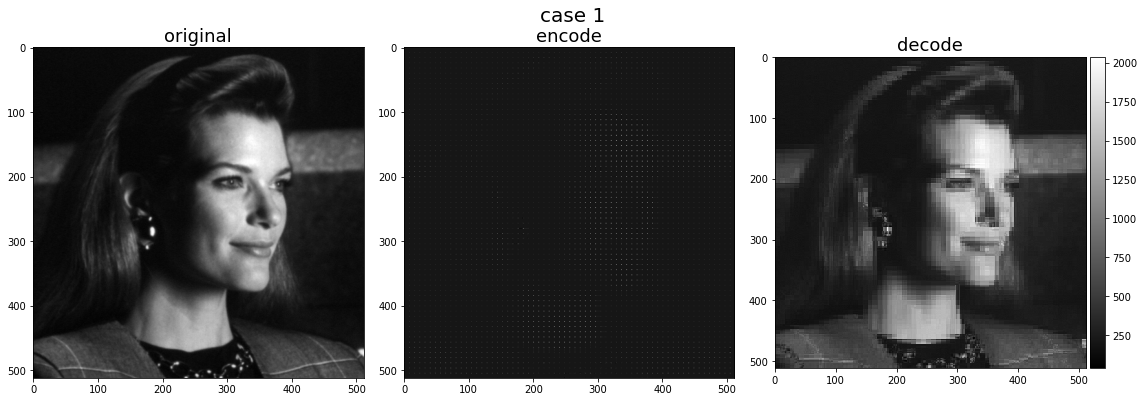

In [279]:
lst = [im4, forward1, backward1]
labels = ['original', 'encode', 'decode']
f, axarr = plt.subplots(1, 3)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
fig.suptitle('case 1', fontsize=20)
for i, label in enumerate(labels):
    axarr[i].imshow(lst[i], cmap='gray')
    axarr[i].set_title(label, fontsize=18)
io.imshow(inversed_DFT_img, cmap='gray')

In [275]:
print(root_mean_sq_error(im4, backward))
print(mean_sq_signal_to_noise_ratio(im4, backward))

546.4078626569918
1.3048424361961843


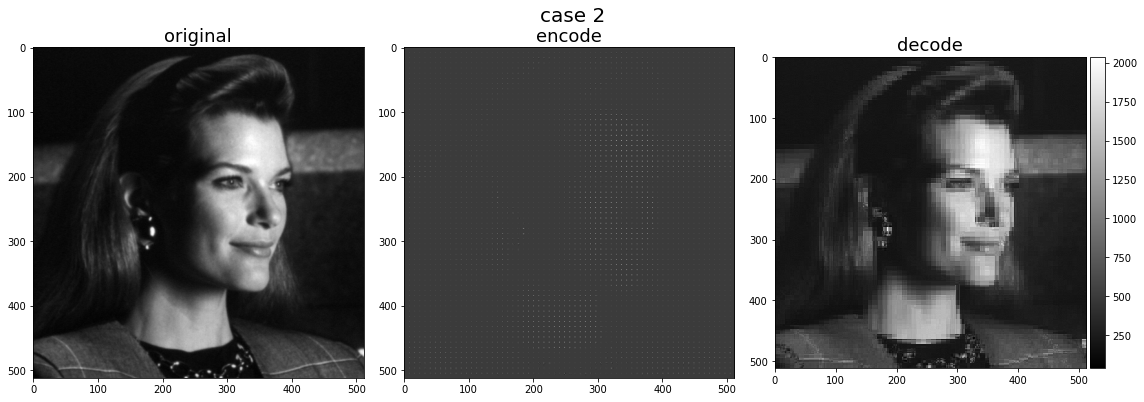

In [280]:
forward2 = encode(im4, "Cosine")
backward2 = decode(im4, forward2)
lst = [im4, forward2, backward2]
labels = ['original', 'encode', 'decode']
f, axarr = plt.subplots(1, 3)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
fig.suptitle('case 2', fontsize=20)
for i, label in enumerate(labels):
    axarr[i].imshow(lst[i], cmap='gray')
    axarr[i].set_title(label, fontsize=18)

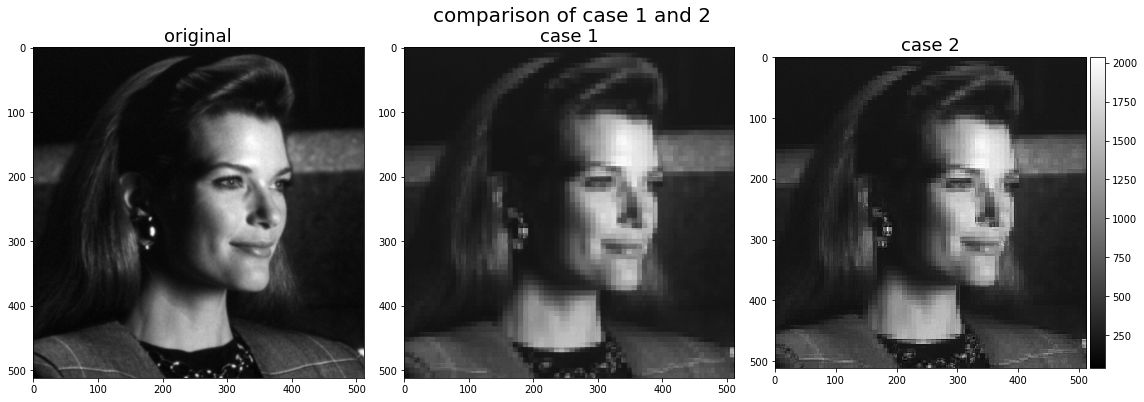

In [282]:
"""case 2 looks more clear and smooth. """
lst = [im4, backward1, backward2]
labels = ['original', 'case 1', 'case 2']
f, axarr = plt.subplots(1, 3)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
fig.suptitle('comparison of case 1 and 2', fontsize=20)
for i, label in enumerate(labels):
    axarr[i].imshow(lst[i], cmap='gray')
    axarr[i].set_title(label, fontsize=18)

/Users/vioichigo/opt/anaconda3/envs/mjrl-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


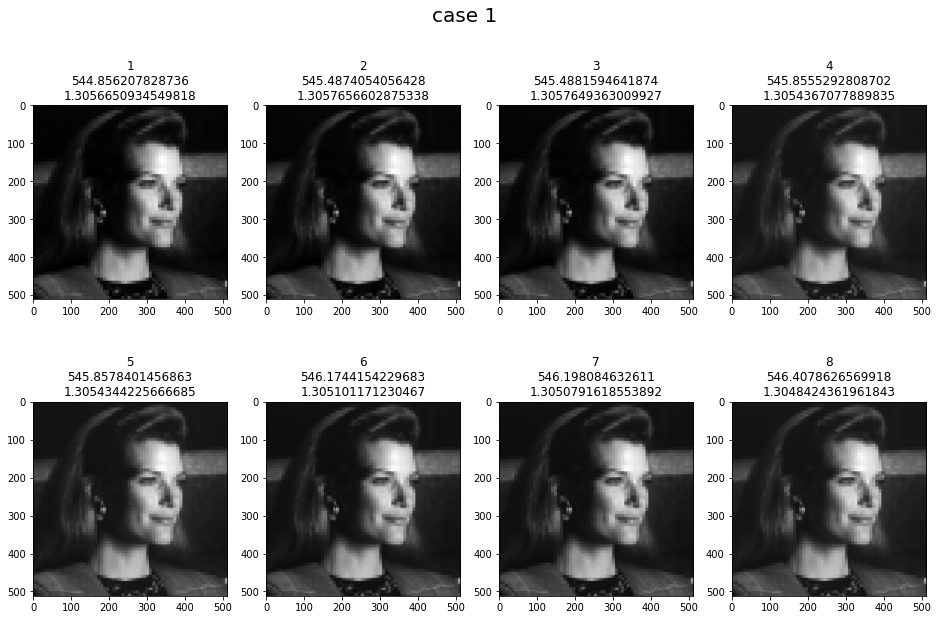

In [295]:
lst = []
for bit in range(1, 9):
    encoded = encode(im4, "Fourier", bit=bit)
    decoded = decode(im4, encoded)
    lst.append(decoded)
#NOTE:
# in each label, it shows 
# number of retained coefficients, 
# root_mean_sq_error
# mean_sq_signal_to_noise_ratio
    
labels = []
for x, decoded in zip(list(range(1, 9)), lst):
    labels.append(str(x)+'\n'+str(root_mean_sq_error(im4, decoded))+'\n'+str(mean_sq_signal_to_noise_ratio(im4, decoded)))
f, axarr = plt.subplots(2, 4)
fig = plt.gcf()
fig.set_size_inches(16, 10)
fig.suptitle('case 1', fontsize=20)
for idx, label in enumerate(labels):
    i, j = idx//4, idx%4
    axarr[i, j].imshow(lst[idx], cmap='gray')
    axarr[i, j].set_title(label, fontsize=12)

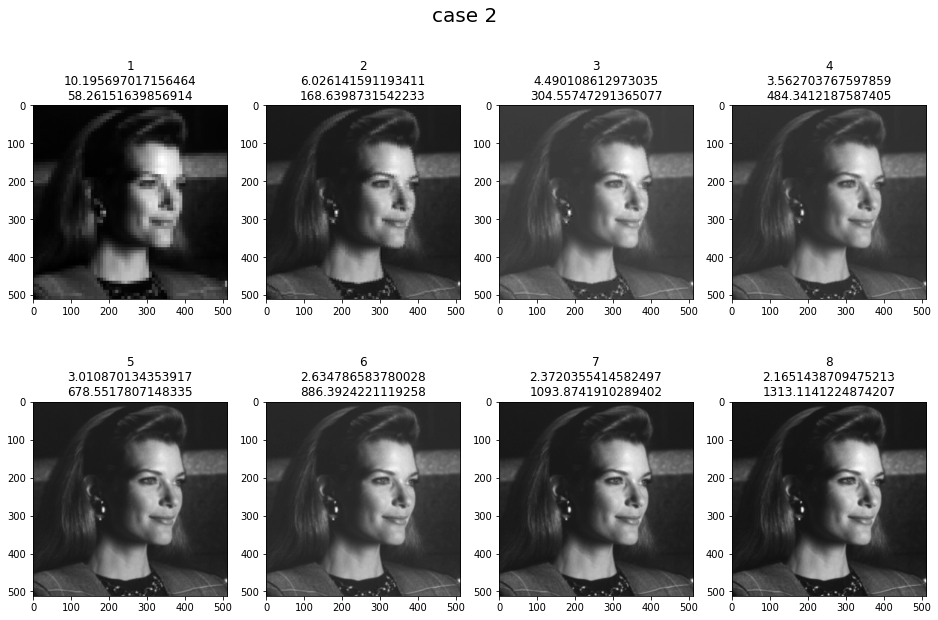

In [296]:
lst = []
for bit in range(1, 9):
    encoded = encode(im4, "Cosine", bit)
    decoded = decode(im4, encoded)
    lst.append(decoded)
#NOTE:
# in each label, it shows 
# number of retained coefficients, 
# root_mean_sq_error
# mean_sq_signal_to_noise_ratio
    
labels = []
for x, decoded in zip(list(range(1, 9)), lst):
    labels.append(str(x)+'\n'+str(root_mean_sq_error(im4, decoded))+'\n'+str(mean_sq_signal_to_noise_ratio(im4, decoded)))
f, axarr = plt.subplots(2, 4)
fig = plt.gcf()
fig.set_size_inches(16, 10)
fig.suptitle('case 2', fontsize=20)
for idx, label in enumerate(labels):
    i, j = idx//4, idx%4
    axarr[i, j].imshow(lst[idx], cmap='gray')
    axarr[i, j].set_title(label, fontsize=12)